<a href="https://colab.research.google.com/github/Congliu0829/cencus_dnn_caching/blob/master/%E2%80%9CCensus_income_ipynb_1%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
import os
import time
from sklearn import preprocessing
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())


Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'


import torch
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install torch==0.4.1
!pip install torchvision==0.2.2
!pip install Pillow==6.2.2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pickle
from torch.utils.data.sampler import (SubsetRandomSampler,RandomSampler)


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
    
print(device)

cpu


In [5]:
full_data = pd.read_csv(
    "/content/adult.csv",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python', skiprows=1,
        na_values="?", dtype={0:int, 1:str, 2:int, 3:str, 4:int, 5: str, 6:str , 7:str ,8:str ,9: str, 10:int, 11:int, 12:int, 13:str,14: str})

print('Dataset size: ', full_data.shape[0])

Dataset size:  32561


In [6]:
print(full_data.head())
print(full_data.shape)

   Age  Workclass  fnlwgt  ... Hours per week          Country   Target
0   90        "?"   77053  ...             40  "United-States"  "<=50K"
1   82  "Private"  132870  ...             18  "United-States"  "<=50K"
2   66        "?"  186061  ...             40  "United-States"  "<=50K"
3   54  "Private"  140359  ...             40  "United-States"  "<=50K"
4   41  "Private"  264663  ...             40  "United-States"  "<=50K"

[5 rows x 15 columns]
(32561, 15)


In [7]:
str_list=[] 
for data in [full_data]:
    for colname, colvalue in data.iteritems(): 
        if type(colvalue[1]) == str:
            str_list.append(colname) 
num_list = data.columns.difference(str_list) #seperate str with int in input data

In [8]:
full_size = full_data.shape[0]
print('Dataset size Before pruning: ', full_size)
for data in [full_data]:
    for i in full_data:
        data[i].replace('NaN', np.nan, inplace=True)
    data.dropna(inplace=True)
real_size = full_data.shape[0]
print('Dataset size after pruning: ', real_size)
print('We eliminated ', (full_size-real_size), ' datapoints')

Dataset size Before pruning:  32561
Dataset size after pruning:  32561
We eliminated  0  datapoints


In [9]:
full_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,90,"""?""",77053,"""HS-grad""",9,"""Widowed""","""?""","""Not-in-family""","""White""","""Female""",0,4356,40,"""United-States""","""<=50K"""
1,82,"""Private""",132870,"""HS-grad""",9,"""Widowed""","""Exec-managerial""","""Not-in-family""","""White""","""Female""",0,4356,18,"""United-States""","""<=50K"""
2,66,"""?""",186061,"""Some-college""",10,"""Widowed""","""?""","""Unmarried""","""Black""","""Female""",0,4356,40,"""United-States""","""<=50K"""
3,54,"""Private""",140359,"""7th-8th""",4,"""Divorced""","""Machine-op-inspct""","""Unmarried""","""White""","""Female""",0,3900,40,"""United-States""","""<=50K"""
4,41,"""Private""",264663,"""Some-college""",10,"""Separated""","""Prof-specialty""","""Own-child""","""White""","""Female""",0,3900,40,"""United-States""","""<=50K"""


In [10]:
full_labels = full_data['Target'].copy()
print(full_labels.shape[0])

full_data = full_data.drop(['Target'], axis=1)
print(full_data.shape[0])

# Label Encode Labels
label_encoder = LabelEncoder()
full_labels = label_encoder.fit_transform(full_labels)
print(full_labels[:10])

32561
32561
[0 0 0 0 0 0 0 1 0 1]


In [11]:
cat_data = full_data.select_dtypes(include=['object']).copy()
other_data = full_data.select_dtypes(include=['int']).copy()
print(cat_data.head())
print(cat_data.shape)
print(other_data.shape)#seperate data by objects and numbers 

   Workclass       Education Martial Status  ...     Race       Sex          Country
0        "?"       "HS-grad"      "Widowed"  ...  "White"  "Female"  "United-States"
1  "Private"       "HS-grad"      "Widowed"  ...  "White"  "Female"  "United-States"
2        "?"  "Some-college"      "Widowed"  ...  "Black"  "Female"  "United-States"
3  "Private"       "7th-8th"     "Divorced"  ...  "White"  "Female"  "United-States"
4  "Private"  "Some-college"    "Separated"  ...  "White"  "Female"  "United-States"

[5 rows x 8 columns]
(32561, 8)
(32561, 6)


In [12]:
newcat_data = pd.get_dummies(cat_data, columns=[
    "Workclass", "Education", "Country" ,"Relationship", "Martial Status", "Occupation", "Relationship",
    "Race", "Sex"
])# apply a encoder for str catagories

In [13]:
newcat_data.head()

,"Workclass_""?""","Workclass_""Federal-gov""","Workclass_""Local-gov""","Workclass_""Never-worked""","Workclass_""Private""","Workclass_""Self-emp-inc""","Workclass_""Self-emp-not-inc""","Workclass_""State-gov""","Workclass_""Without-pay""","Education_""10th""","Education_""11th""","Education_""12th""","Education_""1st-4th""","Education_""5th-6th""","Education_""7th-8th""","Education_""9th""","Education_""Assoc-acdm""","Education_""Assoc-voc""","Education_""Bachelors""","Education_""Doctorate""","Education_""HS-grad""","Education_""Masters""","Education_""Preschool""","Education_""Prof-school""","Education_""Some-college""","Country_""?""","Country_""Cambodia""","Country_""Canada""","Country_""China""","Country_""Columbia""","Country_""Cuba""","Country_""Dominican-Republic""","Country_""Ecuador""","Country_""El-Salvador""","Country_""England""","Country_""France""","Country_""Germany""","Country_""Greece""","Country_""Guatemala""","Country_""Haiti""",...,"Relationship_""Not-in-family""","Relationship_""Other-relative""","Relationship_""Own-child""","Relationship_""Unmarried""","Relationship_""Wife""","Martial Status_""Divorced""","Martial Status_""Married-AF-spouse""","Martial Status_""Married-civ-spouse""","Martial Status_""Married-spouse-absent""","Martial Status_""Never-married""","Martial Status_""Separated""","Martial Status_""Widowed""","Occupation_""?""","Occupation_""Adm-clerical""","Occupation_""Armed-Forces""","Occupation_""Craft-repair""","Occupation_""Exec-managerial""","Occupation_""Farming-fishing""","Occupation_""Handlers-cleaners""","Occupation_""Machine-op-inspct""","Occupation_""Other-service""","Occupation_""Priv-house-serv""","Occupation_""Prof-specialty""","Occupation_""Protective-serv""","Occupation_""Sales""","Occupation_""Tech-support""","Occupation_""Transport-moving""","Relationship_""Husband""","Relationship_""Not-in-family""","Relationship_""Other-relative""","Relationship_""Own-child""","Relationship_""Unmarried""","Relationship_""Wife""","Race_""Amer-Indian-Eskimo""","Race_""Asian-Pac-Islander""","Race_""Black""","Race_""Other""","Race_""White""","Sex_""Female""","Sex_""Male"""
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0


In [14]:
full_data = pd.concat([other_data, newcat_data], axis=1)

In [15]:
print(full_data.head())

   Age  fnlwgt  Education-Num  ...  Race_"White"  Sex_"Female"  Sex_"Male"
0   90   77053              9  ...             1             1           0
1   82  132870              9  ...             1             1           0
2   66  186061             10  ...             0             1           0
3   54  140359              4  ...             1             1           0
4   41  264663             10  ...             1             1           0

[5 rows x 114 columns]


In [16]:
train_size = 20000
valid_size = 10000

In [17]:
train_x = full_data.iloc[:train_size, :]
train_y = full_labels[:train_size]

print(train_x.shape)
print(train_y.shape)
print()

valid_x = full_data.iloc[train_size:(train_size+valid_size), :]
valid_y = full_labels[train_size:(train_size+valid_size)]
print(valid_x.shape)
print(valid_y.shape)
print()

test_x = full_data.iloc[(train_size+valid_size):, :]
test_y = full_labels[(train_size+valid_size):]
print(test_x.shape)
print(test_y.shape)
num_features = test_x.shape[1]

(20000, 114)
(20000,)

(10000, 114)
(10000,)

(2561, 114)
(2561,)


In [18]:
num_features

114

In [19]:
directory = os.path.dirname('./data_ML/')

try:
    os.stat(directory)
except:
    os.mkdir(directory)

In [20]:
import os, shutil
folder = './data_ML/'
for the_file in os.listdir(folder):
    file_path = os.path.join(folder, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)

!ls "./data_ML/"

In [21]:
full_dataset = np.asarray(full_data).astype(np.float32)
full_labels = np.asarray(full_labels).astype(np.float32)
z=0

# load data for dataloader
start = time.time()
for x in range(full_dataset.shape[0]):
    for y in range(2):
        if full_labels[x] == y: 
            temp = (full_dataset[x,:]) #every row of full_dataset
            
            directory = './data_ML/' + str(label_encoder.classes_[y]) #./data_ML/">50K" or ./data_ML/"<=50K"
            if not os.path.exists(directory):
                os.makedirs(directory)
            
            
            np.save((directory+ '/' +str(z) +'.npy'), temp) # store every row in every directory
            
            z += 1
    
end = time.time()

print('Time to process: ', end-start)
print(z, ' datapoints saved to path')

Time to process:  8.246361494064331
32561  datapoints saved to path


In [25]:
mean = np.zeros(num_features)
std_mean = np.ones(num_features)


class prep_stuff:
    def __init__(self, batch_size, path):
        self.batch_size = batch_size
        self.path = path

        batch_size_eval = 128
          
        self.train_data = datasets.DatasetFolder(self.path, np.load, ('npy'), target_transform=float32 )
   
        
        indices = list(range(len(self.train_data)))
        random.shuffle(indices)

        # Split dataset into train and Test sets
        self.train_loader = DataLoader(
            self.train_data,
            batch_size=self.batch_size,
            sampler=SubsetRandomSampler(indices[:20000]),
            num_workers=1,
        )

        self.valid_loader = DataLoader(
            self.train_data,
            batch_size=self.batch_size,
            sampler=SubsetRandomSampler(indices[20000:30000]),
            num_workers=1,
        )

        self.test_loader = DataLoader(
            self.train_data,
            batch_size=self.batch_size,
            sampler=SubsetRandomSampler(indices[30000:]),
            num_workers=1,
        )




        
           


# Create the object with both loader and loss functions

batchSize = 1000
path = './data_ML/'

# 20000 for train
# 10000 for valid 
# 2561 for Test
pre_model = prep_stuff(batchSize, path)

In [ ]:
for x,y in pre_model.train_loader:
  print(y.dtype)

In [23]:
class BasicNet(nn.Module):
    
    def __init__(self, num_features, num_classes=1):
        super().__init__()
        self.num_features = num_features
        # For your dataset this should be 1
        self.num_classes = num_classes
        self.n_layers = 4 
        self.n_features = {1: num_features, 2:int(num_features/2), 3:int(num_features/4), 4: int(num_features/8), 5: num_classes}   
        self.lin1 = torch.nn.Linear(self.n_features[1], self.n_features[2])
        self.lin2 = torch.nn.Linear(self.n_features[2], self.n_features[3])
        self.lin3 = torch.nn.Linear(self.n_features[3], self.n_features[4])
        self.lin4 = torch.nn.Linear(self.n_features[4], self.n_features[5])

    def forward(self,x):
      x = F.relu(self.lin1(x))
      x = F.relu(self.lin2(x))
      x = F.relu(self.lin3(x))
      x = self.lin4(x)
      s = nn.Sigmoid()
      x = s(x)
      return x
    
    def get_embedding(self, x, k):
      assert k < 5
      if k == 2:
        x = F.relu(self.lin2(F.relu(self.lin1(x))))
      if k == 3:
        x = F.relu(self.lin3(F.relu(self.lin2(F.relu(self.lin1(x))))))
      return x
        

In [26]:
model = BasicNet(num_features, 1).to(device)
nbr_epochs = 50
lr = 0.0025
weight_decay = 0
loss_plot = 0
loss_lst = []
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)

start_time = time.time()
for epoch in range(nbr_epochs):
    for x, y in pre_model.train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        ŷ = model(x) 
        loss = loss_fn(ŷ, y)
        loss_plot = loss.item()
        loss.backward(retain_graph=True)
        optimizer.step()
        loss_lst.append(loss_plot)
  
end_time = time.time()
print('spend',end_time-start_time,'seconds to train this model')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


spend 259.4730644226074 seconds to train this model


In [27]:
len(loss_lst)

1000

With lr= 0.0025 , Batch size of  1000  and 
Neural Network has  4  layers


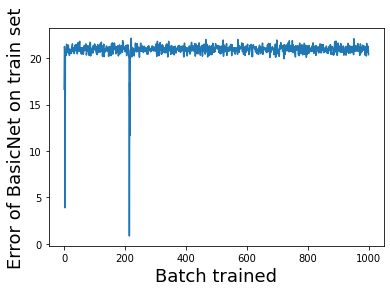

In [29]:
xvalues= np.arange(0,nbr_epochs*int(train_size/batchSize),1)
plt.xlabel('Batch trained', fontsize=18)
plt.ylabel('Error of BasicNet on train set', fontsize=18)
plt.plot(xvalues, loss_lst)

print('With lr=',lr, ', Batch size of ', batchSize ,' and ')
print('Neural Network has ', 4, ' layers')

In [30]:
class Cache:
    def __init__(self, n_layers):
        self.embeddings = {i: [] for i in range(1,n_layers+1)}
    @property
    def size(self):
        return len(self.embeddings)

    @property
    def get(self, i):
        assert i < len(self.embeddings)
        return self.embeddings[i]
    
    def store(self, x, i):
        self.embeddings[i].append(x)

In [31]:
cache = Cache(2) # we'll use only the hidden layers
cache_t = Cache(2)
for epoch in range(nbr_epochs):
    for x, y in pre_model.train_loader:
        # model.step
        
        x, y = x.to(device), y.to(device)
        h2 = model.get_embedding(x, 2) 
        cache.store(h2, 1)
        
        h3 = model.get_embedding(x, 3) 
        cache.store(h3, 2)
for t_x, t_y in pre_model.valid_loader:
    t_x, t_y = t_x.to(device), t_y.to(device)
    t_h2 = model.get_embedding(t_x, 2)
    cache_t.store(t_h2,1)
    t_h3 = model.get_embedding(t_x, 3)
    cache_t.store(t_h3,2)


In [34]:
class AutoEncoder(nn.Module):
    def __init__(self, indim, outdim):
        super(AutoEncoder, self).__init__()
        self.indim = indim
        self.outdim = outdim
        
        self.hidden_e = nn.Sequential(nn.Linear(indim, int(indim/2)),nn.ReLU(),nn.Linear(int(indim/2), outdim))
        
        self.hidden_d = nn.Sequential(nn.Linear(outdim, int(indim/2)),nn.ReLU(),nn.Linear(int(indim/2), indim))
        
    def encode(self, x):
        return self.hidden_e(x)
    
    def decode(self, x):
        return self.hidden_d(x)
    
    def forward(self, x):
        return self.decode(self.encode(x))

In [35]:
cache.embeddings[1] = cache.embeddings[1][len(cache.embeddings[1]) - 20:]
cache.embeddings[2] = cache.embeddings[2][len(cache.embeddings[2]) - 20:]

In [38]:
AE2 = AutoEncoder(28, 3) ## Not sure what's a good output dimensionality here (check based on your model)
AE3 = AutoEncoder(14, 3)

AE2_loss = nn.MSELoss()
AE3_loss = nn.MSELoss()
l2_loss = [] # store train loss
l3_loss = []
t_l2_loss = []  #store test loss
t_l3_loss = []  
l2 = 0  #add loss together for each batch and return to 0 for next batch loss calculation
l3 = 0
t_l2 = 0  
t_l3 = 0
AE2_opt = optim.Adam(AE2.parameters(), lr=0.001)
AE3_opt = optim.Adam(AE3.parameters(), lr=0.001)

for e in range(nbr_epochs):
    for x2 in cache.embeddings[1]:
        #x_encoded = AE2.encode(x) 
        #x_decoded = AE2.encode(x_encoded)
        AE2_opt.zero_grad()
        x2_decoded = AE2(x2)
        l2 = AE2_loss(x2_decoded, x2)
        l2_error = AE2_loss(x2_decoded, x2)
        l2_error.backward(retain_graph=True)
        AE2_opt.step() 
        l2_loss.append(l2.item())

    for x3 in cache.embeddings[2]:
        #x_encoded = AE3.encode(x) 
        #x_decoded = AE3.encode(x_encoded)
        AE3_opt.zero_grad()
        x3_decoded = AE3(x3)
        l3 = AE3_loss(x3_decoded, x3)
        l3_error = AE3_loss(x3_decoded, x3)
        l3_error.backward(retain_graph=True)
        AE3_opt.step()
        l3_loss.append(l3.item())

    for t_x2 in cache_t.embeddings[1]:
      t_x2_decoded = AE2(t_x2)
      t_l2 = AE2_loss(t_x2_decoded, t_x2)
      t_l2_loss.append(t_l2.item())

    for t_x3 in cache_t.embeddings[2]:
      t_x3_decoded = AE3(t_x3)
      t_l3 = AE3_loss(t_x3_decoded, t_x3)
      t_l3_loss.append(t_l3.item())

         

In [43]:
len(cache.embeddings[1])

20

With lr= 0.0025 , Batch size of  1000  and 
Neural Network has  4  layers


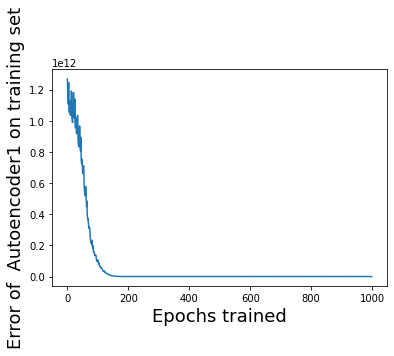

In [44]:
xvalues= np.arange(0,nbr_epochs*int(train_size/batchSize),1)
plt.xlabel('Batch trained', fontsize=18)
plt.ylabel('Error of  Autoencoder1 on training set', fontsize=18)
plt.plot(xvalues, l2_loss)

print('With lr=',lr, ', Batch size of ', batchSize ,' and ')
print('Neural Network has ', model.n_layers, ' layers')

With lr= 0.0025 , Batch size of  1000  and 
Neural Network has  4  layers


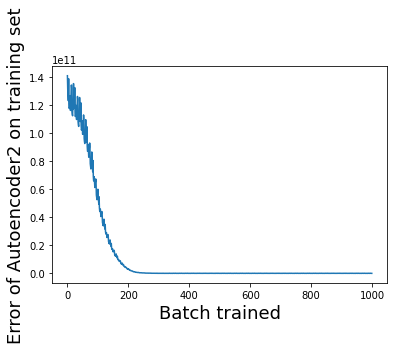

In [47]:
xvalues= np.arange(0,nbr_epochs*int(train_size/batchSize),1)
plt.xlabel('Batch trained', fontsize=18)
plt.ylabel('Error of Autoencoder2 on training set', fontsize=18)
plt.plot(xvalues, l3_loss)

print('With lr=',lr, ', Batch size of ', batchSize ,' and ')
print('Neural Network has ', 4, ' layers')

With lr= 0.0025 , Batch size of  1000  and 
Neural Network has  4  layers


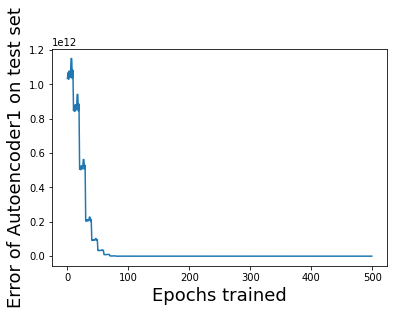

In [45]:
xvalues= np.arange(0,nbr_epochs*int(valid_size/batchSize),1)
plt.xlabel('Epochs trained', fontsize=18)
plt.ylabel('Error of Autoencoder1 on test set', fontsize=18)
plt.plot(xvalues, t_l2_loss)

print('With lr=',lr, ', Batch size of ', batchSize ,' and ')
print('Neural Network has ', model.n_layers, ' layers')

With lr= 0.0025 , Batch size of  1000  and 
Neural Network has  4  layers


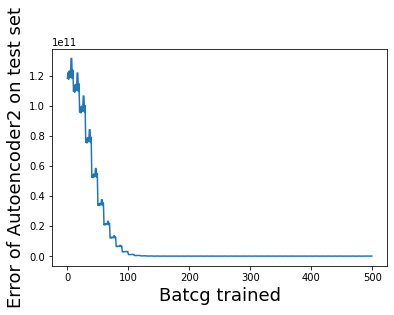

In [46]:
xvalues= np.arange(0,nbr_epochs*int(valid_size/batchSize),1)
plt.xlabel('Batcg trained', fontsize=18)
plt.ylabel('Error of Autoencoder2 on test set', fontsize=18)
plt.plot(xvalues, t_l3_loss)

print('With lr=',lr, ', Batch size of ', batchSize ,' and ')
print('Neural Network has ', 4, ' layers')